Definição do Problema:

- Qual time ganhará o Brasileirão de 2023?
- Será o time do Palmeiras ou Flamengo?
- Qual top 3 times esperados para o campeonato Brasileirão 2023?

In [1]:
# Importando as bibliotecas padrões
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca padrão para trabalhar com datas
from datetime import datetime

# Importando a biblioteca para carregar arquivos do drive
from google.colab import drive

# Importando as bibliotecas de modelo
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

# Importandoa as bibliotecas de métricas
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

 Leitura da base consumida

In [3]:
# informa o arquivo XLSX de importacao para o dataset
file_xlsx = 'https://raw.githubusercontent.com/michelleamesquita/puc-mvp-3/main/campeonato-brasileiro-full.csv'

# lê o arquivo na pasta raiz do projeto

df = pd.read_csv(file_xlsx, delimiter=',', skiprows=0, low_memory=False)

Olhando brevemente os dados

In [4]:
df.head()

,ID,rodata,data,hora,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_Placar,visitante_Placar,mandante_Estado,visitante_Estado
0,1,1,29/03/2003,16:00,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,Brinco de Ouro,4,2,SP,RJ
1,2,1,29/03/2003,16:00,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,Arena da Baixada,2,0,PR,RS
2,3,1,30/03/2003,16:00,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,Maracanã,1,1,RJ,PR
3,4,1,30/03/2003,16:00,Goias,Paysandu,NaN,NaN,NaN,NaN,-,Serra Dourada,2,2,GO,PA
4,5,1,30/03/2003,16:00,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,Beira Rio,1,1,RS,SP


In [5]:
# Olhando o tipo de cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405 entries, 0 to 8404
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  8405 non-null   int64 
 1   rodata              8405 non-null   int64 
 2   data                8405 non-null   object
 3   hora                8405 non-null   object
 4   mandante            8405 non-null   object
 5   visitante           8405 non-null   object
 6   formacao_mandante   3431 non-null   object
 7   formacao_visitante  3431 non-null   object
 8   tecnico_mandante    3795 non-null   object
 9   tecnico_visitante   3795 non-null   object
 10  vencedor            8405 non-null   object
 11  arena               8405 non-null   object
 12  mandante_Placar     8405 non-null   int64 
 13  visitante_Placar    8405 non-null   int64 
 14  mandante_Estado     8405 non-null   object
 15  visitante_Estado    8405 non-null   object
dtypes: int64(4), object(12)


In [6]:
# Transformando a coluna data de object to datetime
df['date'] = pd.to_datetime(df['data'])

<ipython-input-6-78f89221d493>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['date'] = pd.to_datetime(df['data'])


In [7]:
# Olhando os valores nulos
df.isnull().sum().sort_values(ascending=False)

formacao_mandante     4974
formacao_visitante    4974
tecnico_mandante      4610
tecnico_visitante     4610
vencedor                 0
visitante_Estado         0
mandante_Estado          0
visitante_Placar         0
mandante_Placar          0
arena                    0
ID                       0
rodata                   0
visitante                0
mandante                 0
hora                     0
data                     0
date                     0
dtype: int64

In [8]:
# Definindo vencedor
def change_winner_name(row):
    if (row['vencedor'] == row['mandante']):
        return 0
    elif (row['vencedor'] == row['visitante']):
        return 1
    else:
        return 2

df['vencedor'] = df.apply(change_winner_name, axis=1)

In [9]:
# Olhando a quantidade de cada resultado, vemos que a maioria dos jogos não acaba em empate
df['vencedor'].value_counts().sort_values(ascending=False)

0    4179
2    2221
1    2005
Name: vencedor, dtype: int64

Engenharia das variáveis

In [10]:
df['temporada'] = df['date'].dt.year

In [11]:
# Vamos apagar as colunas que no primeiro momento não são muito importantes

# Não importa a cidade ou pais, o mais importante é saber se a localização é neutra ou não

df = df.drop(['arena','formacao_mandante','formacao_visitante','tecnico_mandante','tecnico_visitante','mandante_Estado','visitante_Estado'],axis=1)

In [12]:
# A maioria dos empates do brasileirao termina 1x1
numero_empates = df[df['vencedor']== 2]
numero_empates['mandante_Placar'].value_counts().sort_values(ascending=False)

1    1036
0     671
2     430
3      76
4       7
5       1
Name: mandante_Placar, dtype: int64

In [13]:
# A maioria dos times derrotados em casa não marca gol
numero_derrotas = df[df['vencedor']== 1]
numero_derrotas['mandante_Placar'].value_counts().sort_values(ascending=False)

0    1066
1     725
2     172
3      38
4       4
Name: mandante_Placar, dtype: int64

In [14]:
# A maioria dos times vitoriosos em casa vence com 2 gols
numero_derrotas = df[df['vencedor']== 0]
numero_derrotas['mandante_Placar'].value_counts().sort_values(ascending=False)

2    1521
1    1110
3     966
4     413
5     125
6      37
7       7
Name: mandante_Placar, dtype: int64

In [15]:
# Confrontos diretos para descobrir o historico de vantagens

df['home_Agnst'] = 0
df['away_Agnst'] = 0
df['draws_Agnst'] = 0

clubs = df['mandante'].value_counts().index.sort_values().values

for club1 in clubs:
    for club2 in clubs:
        dfc = df[((df['mandante'] == club1) & (df['visitante'] == club2)) | ((df['visitante'] == club1) & (df['visitante'] == club2))]
        win_home = 0
        win_away = 0
        draws = 0
        for index, row in dfc.iterrows():
            df.at[index, 'home_Agnst'] = win_home
            df.at[index, 'away_Agnst'] = win_away
            df.at[index, 'draws_Agnst'] = draws

            if row['vencedor'] == 0:
                win_home +=1
            elif row['vencedor'] == 1:
                win_away +=1
            else:
                draws+=1


In [16]:
# Clubes promovidos para descobrir se estava nos anos anteriores na serie A

temporadas = df['temporada'].value_counts().index.sort_values().values

df['is_Promoted'] = 0
df['is_Promoted_Away'] = 0

for temporada in temporadas[1:]:
    dft = df[df['temporada'] == temporada]

    dfw = df[df['temporada'] == temporada-1]

    for index, row in dft.iterrows():
        last_year_clubs = dfw['mandante'].value_counts().index.sort_values().values

        home_club = row['mandante']
        if home_club in last_year_clubs:
            df.at[index, 'is_Promoted'] = 0
        else:
            df.at[index, 'is_Promoted'] = 1

        away_club = row['visitante']
        if away_club in last_year_clubs:
            df.at[index, 'is_Promoted_Away'] = 0
        else:
            df.at[index, 'is_Promoted_Away'] = 1


In [17]:
df[df['vencedor']== 0]

,ID,rodata,data,hora,mandante,visitante,vencedor,mandante_Placar,visitante_Placar,date,temporada,home_Agnst,away_Agnst,draws_Agnst,is_Promoted,is_Promoted_Away
0,1,1,29/03/2003,16:00,Guarani,Vasco,0,4,2,2003-03-29,2003,0,0,0,0,0
1,2,1,29/03/2003,16:00,Athletico-PR,Gremio,0,2,0,2003-03-29,2003,0,0,0,0,0
5,6,1,30/03/2003,16:00,Criciuma,Fluminense,0,2,0,2003-03-30,2003,0,0,0,0,0
15,16,2,05/04/2003,18:00,Gremio,Guarani,0,3,1,2003-05-04,2003,0,0,0,0,0
19,20,2,06/04/2003,16:00,Ponte Preta,Juventude,0,1,0,2003-06-04,2003,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8396,8397,38,06/12/2023,21:32,Internacional,Botafogo-RJ,0,3,1,2023-06-12,2023,9,6,1,0,0
8400,8401,38,06/12/2023,21:32,Bahia,Atletico-MG,0,4,1,2023-06-12,2023,1,2,7,1,0
8401,8402,38,06/12/2023,21:32,Cuiaba,Athletico-PR,0,3,0,2023-06-12,2023,1,1,0,0,0
8403,8404,38,06/12/2023,21:32,Sao Paulo,Flamengo,0,1,0,2023-06-12,2023,9,4,7,0,0


In [18]:
# Criando uma variável que junta o score da ataque (midfield + offense)
df['home_attack'] = df[df['vencedor']== 0]['mandante_Placar']
df['home_defense'] = df[df['vencedor']== 1]['visitante_Placar']

df['away_attack'] = df[df['vencedor']== 1]['mandante_Placar']
df['away_defense'] = df[df['vencedor']== 0]['visitante_Placar']

Dividindo em treino e teste

Para realizar a predição escolhi fazer uma especie de janela de expansão:
- Vou usar o dado de 2019 para prever 2020.
- Os dados de 2019 + 2020 para prever 2021.
- Os dados de 2019 + 2020 + 2021 para prever 2022.
- E por fim os dados de 2019 + 2020 + 2021 + 2022 para prever 2023.

In [19]:
bra_2019 = df[df['date'].dt.year ==2019]
bra_2020 = df[df['date'].dt.year ==2020]
bra_2021 = df[df['date'].dt.year ==2021]
bra_2022 = df[df['date'].dt.year ==2022]
bra_2023 = df[df['date'].dt.year ==2023]

In [20]:
treino = bra_2019
valid_1 = bra_2020
valid_2 = bra_2021
valid_3 = bra_2022
teste = bra_2023

In [21]:
# Preenchendo as variáveis nulas (estes geralmente de seleções com menos tradição), com os menores scores

treino['away_defense'] = treino['away_defense'].fillna(treino['away_defense'].min())
treino['home_defense'] = treino['home_defense'].fillna(treino['home_defense'].min())
treino['home_attack'] = treino['home_attack'].fillna(treino['home_attack'].min())
treino['away_attack'] = treino['away_attack'].fillna(treino['away_attack'].min())

valid_1['away_defense'] = valid_1['away_defense'].fillna(valid_1['away_defense'].min())
valid_1['home_defense'] = valid_1['home_defense'].fillna(valid_1['home_defense'].min())
valid_1['home_attack'] = valid_1['home_attack'].fillna(valid_1['home_attack'].min())
valid_1['away_attack'] = valid_1['away_attack'].fillna(valid_1['away_attack'].min())

valid_2['away_defense'] = valid_2['away_defense'].fillna(valid_2['away_defense'].min())
valid_2['home_defense'] = valid_2['home_defense'].fillna(valid_2['home_defense'].min())
valid_2['home_attack'] = valid_2['home_attack'].fillna(valid_2['home_attack'].min())
valid_2['away_attack'] = valid_2['away_attack'].fillna(valid_2['away_attack'].min())

valid_3['away_defense'] = valid_3['away_defense'].fillna(valid_3['away_defense'].min())
valid_3['home_defense'] = valid_3['home_defense'].fillna(valid_3['home_defense'].min())
valid_3['home_attack'] = valid_3['home_attack'].fillna(valid_3['home_attack'].min())
valid_3['away_attack'] = valid_3['away_attack'].fillna(valid_3['away_attack'].min())

teste['away_defense'] = teste['away_defense'].fillna(teste['away_defense'].min())
teste['home_defense'] = teste['home_defense'].fillna(teste['home_defense'].min())
teste['home_attack'] = teste['home_attack'].fillna(teste['home_attack'].min())
teste['away_attack'] = teste['away_attack'].fillna(teste['away_attack'].min())

<ipython-input-21-b28de9d8f421>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['away_defense'] = treino['away_defense'].fillna(treino['away_defense'].min())
<ipython-input-21-b28de9d8f421>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['home_defense'] = treino['home_defense'].fillna(treino['home_defense'].min())
<ipython-input-21-b28de9d8f421>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [22]:
# O score do time é a soma dos scores de ataque e defesa
treino['home_score'] = treino['home_attack'] + treino['home_defense']
treino['away_score'] = treino['away_attack'] + treino['away_defense']

valid_1['home_score'] = valid_1['home_attack'] + valid_1['home_defense']
valid_1['away_score'] = valid_1['away_attack'] + valid_1['away_defense']

valid_2['home_score'] = valid_2['home_attack'] + valid_2['home_defense']
valid_2['away_score'] = valid_2['away_attack'] + valid_2['away_defense']

valid_3['home_score'] = valid_3['home_attack'] + valid_3['home_defense']
valid_3['away_score'] = valid_3['away_attack'] + valid_3['away_defense']

teste['home_score'] = teste['home_attack'] + teste['home_defense']
teste['away_score'] = teste['away_attack'] + teste['away_defense']

<ipython-input-22-690fa7800af9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['home_score'] = treino['home_attack'] + treino['home_defense']
<ipython-input-22-690fa7800af9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['away_score'] = treino['away_attack'] + treino['away_defense']
<ipython-input-22-690fa7800af9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [23]:
# Selecionando as variaveis do modelo  'diff_goal',
xvariaveis = [ 'home_score','away_score', 'mandante_Placar','visitante_Placar','home_Agnst','away_Agnst','draws_Agnst','is_Promoted','is_Promoted_Away' ]

In [24]:
# Separando Variável X e y
y_treino = treino['vencedor']
X_treino= treino[xvariaveis]

y_valid_1 = valid_1['vencedor']
X_valid_1= valid_1[xvariaveis]

y_valid_2 = valid_2['vencedor']
X_valid_2= valid_2[xvariaveis]

y_valid_3 = valid_3['vencedor']
X_valid_3= valid_3[xvariaveis]

y_teste = teste['vencedor']
X_teste= teste[xvariaveis]

In [25]:
# Criando o dado de treino com o dado de treino anterior + validação anterior
y_treino_2 = pd.concat([y_treino, y_valid_1], axis=0)
X_treino_2 = pd.concat([X_treino, X_valid_1], axis=0)

y_treino_3 = pd.concat([y_treino_2, y_valid_2], axis=0)
X_treino_3 = pd.concat([X_treino_2, X_valid_2], axis=0)

y_treino_4 = pd.concat([y_treino_3, y_valid_3], axis=0)
X_treino_4 = pd.concat([X_treino_3, X_valid_3], axis=0)

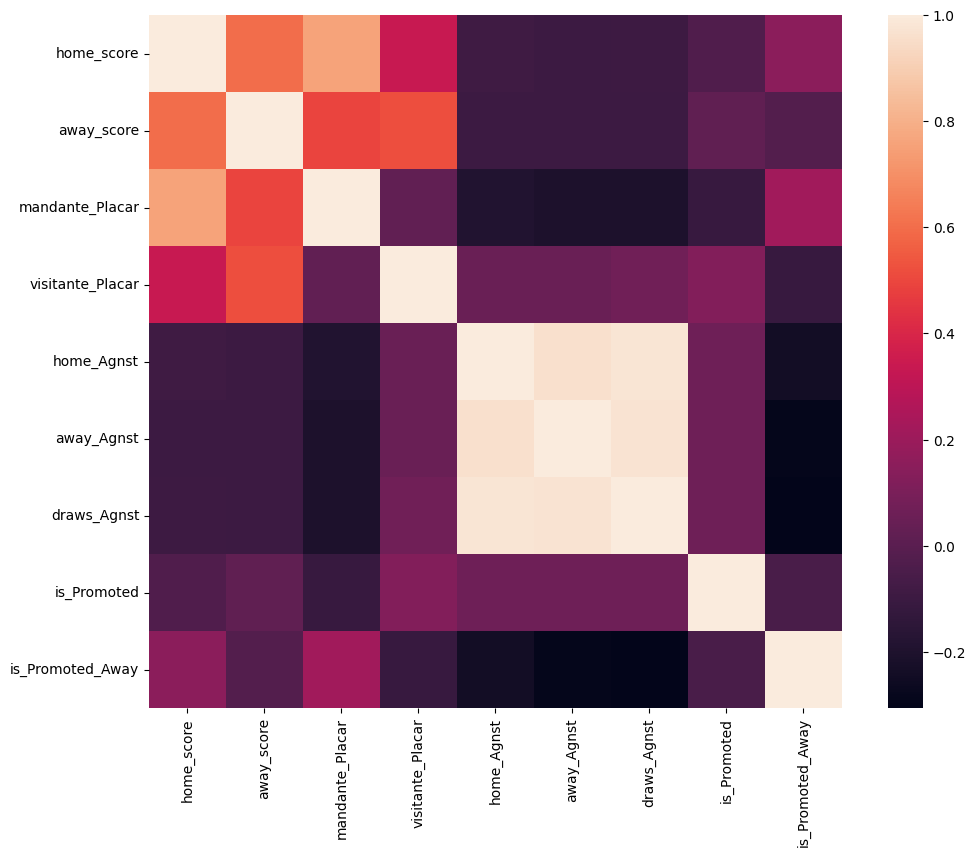

In [26]:
# Olhando se as variavéis são correlacioandas
corrmat = X_treino.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

É possível analisar que existem algumas variáveis bem relacionadas: is_Promoted_Away, draws_Agnst, away_Agnst, home_Agnst

<ipython-input-27-42d2ef2fd5ac>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


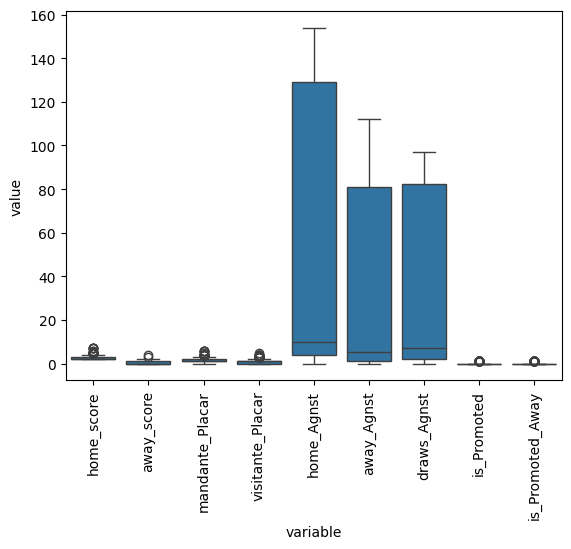

In [27]:
ax = sns.boxplot(x="variable", y="value", data=pd.melt(X_treino[xvariaveis]))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

O boxplot de cada uma das informações serve para verificar quais delas têm pontos muito fora da curva e quais são.



PCA

O modelo PCA é usado para diminuir as dimensões do dataset. Isso permitirá uma análise melhor da base de dados, e também vai traduzir melhor as informações da partida para o modelo

In [28]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [29]:
scaler = preprocessing.StandardScaler()

scaler.fit(X_treino)
X_scaled = scaler.transform(X_treino)

In [30]:
pca = PCA(n_components=5)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_pca_df = pd.DataFrame(X_pca, columns=['V1', 'V2', 'V3', 'V4','V5'])
X_pca_df.tail()

,V1,V2,V3,V4,V5
375,-0.916110,3.978762,1.145714,1.234810,-0.700748
376,0.922548,-1.381702,0.515906,-0.890408,-0.075503
377,1.573605,0.423093,1.674446,1.013034,-1.234750
378,2.100692,0.795439,-1.580974,-0.192374,-1.874816
379,0.491916,-2.045972,1.569248,1.145425,-1.166777


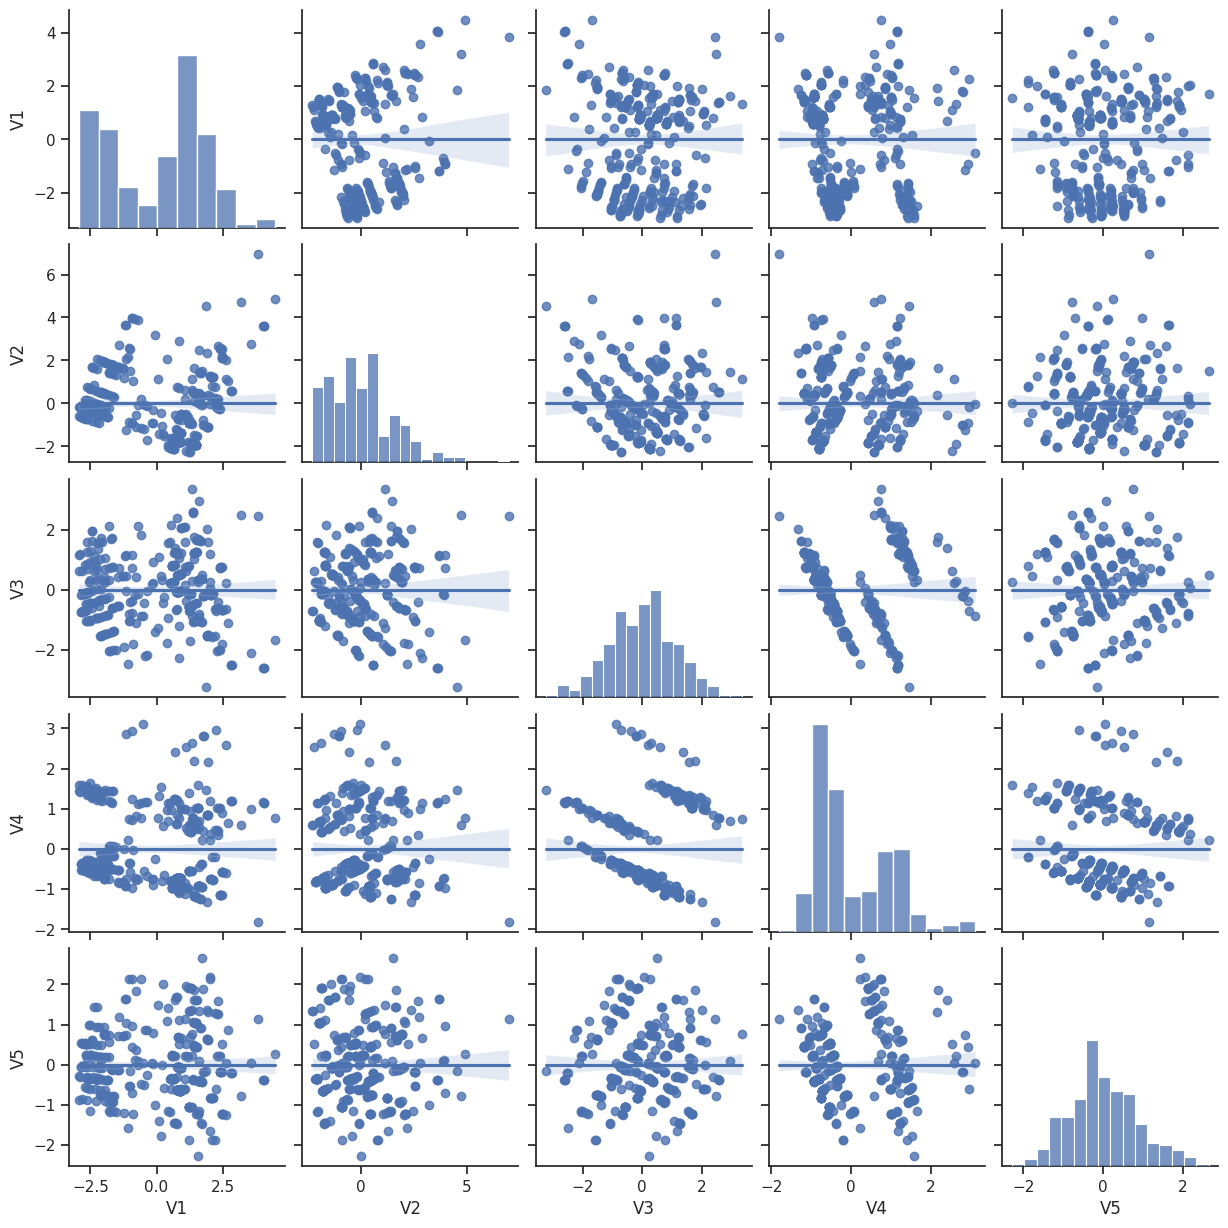

In [31]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(X_pca_df, kind='reg')
plt.show()

ML

O resultado de um modelo de machine learning é dependente dos dados de entrada que o alimentam. Esses dados serão inseridos em uma equação, que retornará o resultado do modelo.
Ele é muito utilizado na previsão de dados que ainda não conhecemos.

In [32]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)

mlp.fit(X_treino, y_treino)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [33]:
modelo = MLPClassifier(random_state=42)
modelo.fit(X_treino, y_treino)
p1 = modelo.predict(X_valid_1)

acc1 = accuracy_score(y_true=y_valid_1, y_pred=p1)
print(acc1)

# matriz de confusão
print(classification_report(y_valid_1, p1))

0.9850746268656716
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      0.95      0.97        73
           2       0.95      1.00      0.97        78

    accuracy                           0.99       268
   macro avg       0.98      0.98      0.98       268
weighted avg       0.99      0.99      0.99       268



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
print("Erro médio quadrático: ",mean_squared_error(y_valid_1,p1))
print("R^2 Score: ", r2_score(y_valid_1,p1))

Erro médio quadrático:  0.014925373134328358
R^2 Score:  0.9788722678807229


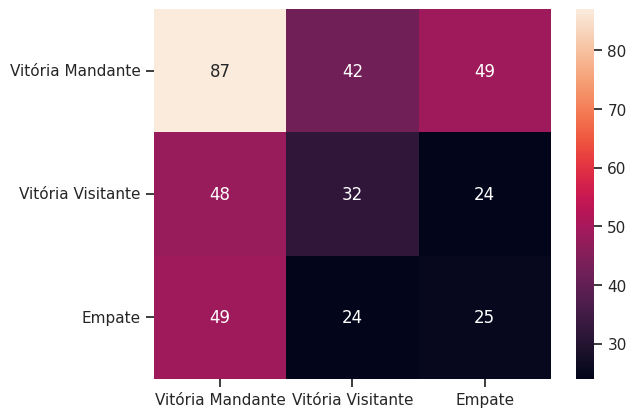

In [35]:
from sys import ps1
from sklearn.metrics import confusion_matrix

y_pred = mlp.predict(X_teste)

cm = confusion_matrix(y_teste, y_treino)

df_cm = pd.DataFrame(cm, index=['Vitória Mandante', 'Vitória Visitante', 'Empate'],
                    columns=['Vitória Mandante', 'Vitória Visitante', 'Empate'])

sns.heatmap(df_cm, annot=True)
plt.show()


In [36]:
modelo = MLPClassifier(random_state=42)
modelo.fit(X_treino_2, y_treino_2)
p2 = modelo.predict(X_valid_2)

acc2 = accuracy_score(y_true=y_valid_2, y_pred=p2)
print(acc2)

# matriz de confusão
print(classification_report(y_valid_2, p2))

0.991869918699187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      0.97      0.98       121
           2       0.97      1.00      0.99       143

    accuracy                           0.99       492
   macro avg       0.99      0.99      0.99       492
weighted avg       0.99      0.99      0.99       492



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [37]:
modelo = MLPClassifier(random_state=42)
modelo.fit(X_treino_3, y_treino_3)
p3 = modelo.predict(X_valid_3)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=p3)
print(acc3)

# matriz de confusão
print(classification_report(y_valid_3, p3))


1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00       104
           2       1.00      1.00      1.00       108

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
media = (acc1 + acc2 +acc3)/3
print(media)

0.9923148485216196


In [39]:
print("Erro médio quadrático: ",mean_squared_error(y_valid_3,p3))
print("R^2 Score: ", r2_score(y_valid_3,p3))

Erro médio quadrático:  0.0
R^2 Score:  1.0


PCA + LogReg

A regressão linear ajuda a usar os dados para melhorar o gerenciamento da realidade. É transformar grandes quantidades de dados brutos em informações acionáveis.

In [40]:
pca = PCA(n_components=9)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_pca_df = pd.DataFrame(X_pca)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y_treino, random_state=0, test_size=0.3)


In [42]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=10)

logreg.fit(X_train, y_train)

p1 = logreg.predict(X_valid_1)

acc1 = accuracy_score(y_true=y_valid_1, y_pred=p1)
print(acc1)

0.2462686567164179


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [43]:
print("Erro médio quadrático: ",mean_squared_error(y_valid_1,p1))
print("R^2 Score: ", r2_score(y_valid_1,p1))

Erro médio quadrático:  0.8880597014925373
R^2 Score:  -0.2571000610969867


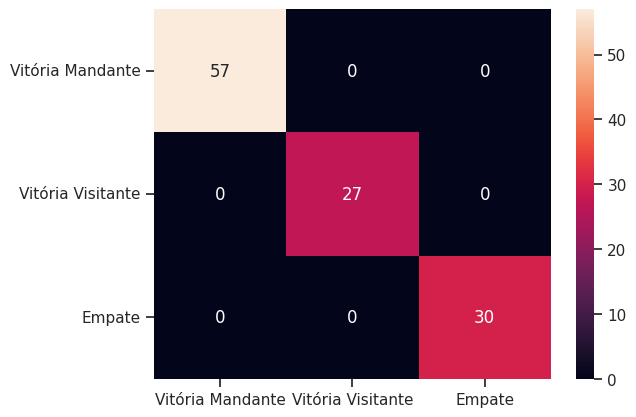

In [44]:
y_pred = logreg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=['Vitória Mandante', 'Vitória Visitante', 'Empate'],
                    columns=['Vitória Mandante', 'Vitória Visitante', 'Empate'])

sns.heatmap(df_cm, annot=True)
plt.show()

In [45]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino_2, y_treino_2)
p2 = modelo.predict(X_valid_2)

acc2 = accuracy_score(y_true=y_valid_2, y_pred=p2)
print((acc2))

# matriz de confusão
print(classification_report(y_valid_2, p2))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00       143

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
modelo = LogisticRegression(C=10)
modelo.fit(X_treino_3, y_treino_3)
p3 = modelo.predict(X_valid_3)

acc3 = accuracy_score(y_true=y_valid_3, y_pred=p3)
print(acc3)

# matriz de confusão
print(classification_report(y_valid_3, p3))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       168
           1       1.00      1.00      1.00       104
           2       1.00      1.00      1.00       108

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
media = (acc1 + acc2 +acc3)/3
print(media)

0.7487562189054726


In [48]:
print("Erro médio quadrático: ",mean_squared_error(y_valid_3,p3))
print("R^2 Score: ", r2_score(y_valid_3,p3))

Erro médio quadrático:  0.0
R^2 Score:  1.0


Treinando o modelo de ML

In [49]:
proba_df = pd.DataFrame(mlp.predict_proba(X_treino_4))
df_r = df.loc[X_treino_4.index,['mandante', 'visitante', 'vencedor']].reset_index(drop=True)

df_rp = df_r.merge(proba_df, left_index=True, right_index=True)


In [50]:
df_rp.columns = ['mandante', 'visitante', 'vencedor', 'p0', 'p1','p2']

Criando uma regra para definir os placares dos jogos:
- Se a probabilidade for maior de empate, então vai 1x1, pois é o placar mais comum de empate na copa.
- Se um time tiver a probalidade de ganhar maior que 0.7, então vai ser 3x0.
- Se um time tiver a probalidade de ganhar maior que 0.6, então vai ser 2x0.
- Se um time tiver a probalidade de ganhar menor que 0.6, então vai ser 1x0.

In [51]:
placar = []
for i in range(0,len(df_rp)):
  if (df_rp.p2[i]> df_rp.p1[i]) and (df_rp.p2[i]> df_rp.p0[i]):
      game='1x1'
  elif df_rp.p1[i]> df_rp.p0[i]:
    if df_rp.p0[i]<0.4:
      home='0'
      if (df_rp.p1[i])*10>7:
        visitor='3'
      elif (df_rp.p1[i])*10>6:
        visitor='2'
      else:
        visitor='1'
      game=home+'x'+visitor
  else:
    if df_rp.p1[i]<0.4:
      visitor='0'
      if (df_rp.p0[i])*10>7:
        home='3'
      elif (df_rp.p0[i])*10>6:
        home='2'
      else:
        home='1'
      game=home+'x'+visitor
  placar.append(game)

In [52]:
df_rp['placar'] = placar

df_rp.head(15)

,mandante,visitante,vencedor,p0,p1,p2,placar
0,Sao Paulo,Botafogo-RJ,0,0.994356,3.097124e-05,0.005613,3x0
1,Atletico-MG,Avai,0,0.926907,2.585564e-02,0.047238,3x0
2,Chapecoense,Internacional,0,0.964470,1.718890e-03,0.033811,3x0
3,Flamengo,Cruzeiro,0,0.999575,1.455919e-05,0.000410,3x0
4,Gremio,Santos,1,0.017580,9.181572e-01,0.064263,0x3
5,Ceara,CSA,0,0.999877,1.940874e-09,0.000123,3x0
6,Bahia,Corinthians,0,0.995006,3.952547e-03,0.001042,3x0
7,Athletico-PR,Vasco,0,0.999213,3.208328e-05,0.000755,3x0
8,Palmeiras,Fortaleza,0,0.999907,1.541909e-09,0.000093,3x0
9,Fluminense,Goias,1,0.011718,6.028427e-01,0.385440,0x2


Capeão da Competição 🏆:

In [67]:
df_rp['Wins_Home_Home_Team'] = df_rp[df_rp['vencedor']== 0]['placar'].astype(str).str[0]
df_rp['Wins_Away_Away_Team'] = df_rp[df_rp['vencedor']== 1]['placar'].astype(str).str[2]
df_rp['Loss_Away_Away_Team'] = df_rp[df_rp['vencedor']== 1]['placar'].astype(str).str[0]
df_rp['Draws_Home_Home_Team'] = df_rp[df_rp['vencedor']== 2]['placar'].astype(str).str[0]
df_rp['Draws_Away_Away_Team'] = df_rp[df_rp['vencedor']== 2]['placar'].astype(str).str[0]

In [68]:
df_rp.head(5)

,mandante,visitante,vencedor,p0,p1,p2,placar,Wins_Home_Home_Team,Loss_Home_Home_Team,Wins_Away_Away_Team,Loss_Away_Away_Team,Draws_Home_Home_Team,Draws_Away_Away_Team
0,Sao Paulo,Botafogo-RJ,0,0.994356,0.000031,0.005613,3x0,3,0,NaN,NaN,NaN,NaN
1,Atletico-MG,Avai,0,0.926907,0.025856,0.047238,3x0,3,0,NaN,NaN,NaN,NaN
2,Chapecoense,Internacional,0,0.964470,0.001719,0.033811,3x0,3,0,NaN,NaN,NaN,NaN
3,Flamengo,Cruzeiro,0,0.999575,0.000015,0.000410,3x0,3,0,NaN,NaN,NaN,NaN
4,Gremio,Santos,1,0.017580,0.918157,0.064263,0x3,NaN,0,3,0,NaN,NaN


In [69]:
times=df_rp['mandante'].unique()

In [94]:
ponto=[]

for time in times:
    p=int(df_rp[df_rp['mandante']==time]['Wins_Home_Home_Team'].count()*3)+int(df_rp[df_rp['mandante']==time]['Loss_Home_Home_Team'].count()*0)+int(df_rp[df_rp['mandante']==time]['Wins_Away_Away_Team'].count()*1)
    ponto.append(p)

In [100]:
df_concat=pd.DataFrame(list(zip(times,ponto)),
              columns=['times','pontos'])

In [101]:
df_concat.sort_values(by=['pontos'], ascending=False).head(3)

,times,pontos
3,Flamengo,170
1,Atletico-MG,162
8,Palmeiras,149


Conclusão



- Flamengo seria o campeão pela quantidade de pontos
- O uso da técnica de ML apresentou um resultado superior ao uso do modelo de regressão linear
- Os dois modelos (ML e regressao linear) tiveram uma probabilidade de 99% de precisão ao usar a técnica com os anos 2019,2020,2021 e 2022
- De acordo com a matriz de correlação foi possível ver que diversos dados escolhidos tinham excelente correlação
- Os três times que ficaram na frente da classificação: Flamengo, Atlético-MG e Palmeiras
- O modelo não sofreu Underfitting e nem Overfitting, pois o modelo conseguiu trazer um excelente resultado ao utilizar os dados de teste, onde no jogo entre Flamengo e Cruzeiro, podemos ver, por exemplo, que houve 99% de chance do Flamengo ter ganhado a partida